
# 6.7-kW SyRM

This example simulates sensorless current-vector control of a 6.7-kW SyRM
drive.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.8 MB/s eta 0:00:00


In [2]:
import numpy as np

from motulator.drive import model
import motulator.drive.control.sm as control
from motulator.drive.utils import (
    BaseValues, NominalValues, plot, Sequence, SynchronousMachinePars)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=370, I=15.5, f=105.8, P=6.7e3, tau=20.1)
base = BaseValues.from_nominal(nom, n_p=2)

Configure the system model.



In [4]:
mdl_par = SynchronousMachinePars(
    n_p=2, R_s=.54, L_d=41.5e-3, L_q=6.2e-3, psi_f=0)
machine = model.SynchronousMachine(mdl_par)
mechanics = model.StiffMechanicalSystem(J=.015)
converter = model.VoltageSourceConverter(u_dc=540)
mdl = model.Drive(converter, machine, mechanics)

Configure the control system. You may also try to change the parameters.



In [5]:
par = mdl_par  # Assume accurate machine model parameter estimates
cfg = control.CurrentReferenceCfg(
    par, nom_w_m=base.w, max_i_s=1.5*base.i, min_psi_s=.5*base.psi, k_u=.9)
ctrl = control.CurrentVectorControl(
    par, cfg, J=.015, T_s=125e-6, sensorless=True)

Set the speed reference and the external load torque.



In [6]:
# Speed reference
times = np.array([0, .125, .25, .375, .5, .625, .75, .875, 1])*4
values = np.array([0, 0, 1, 1, 0, -1, -1, 0, 0])*base.w
ctrl.ref.w_m = Sequence(times, values)
# External load torque
times = np.array([0, .125, .125, .875, .875, 1])*4
values = np.array([0, 0, 1, 1, 0, 0])*nom.tau
mdl.mechanics.tau_L = Sequence(times, values)

Create the simulation object, simulate, and plot results in per-unit values.



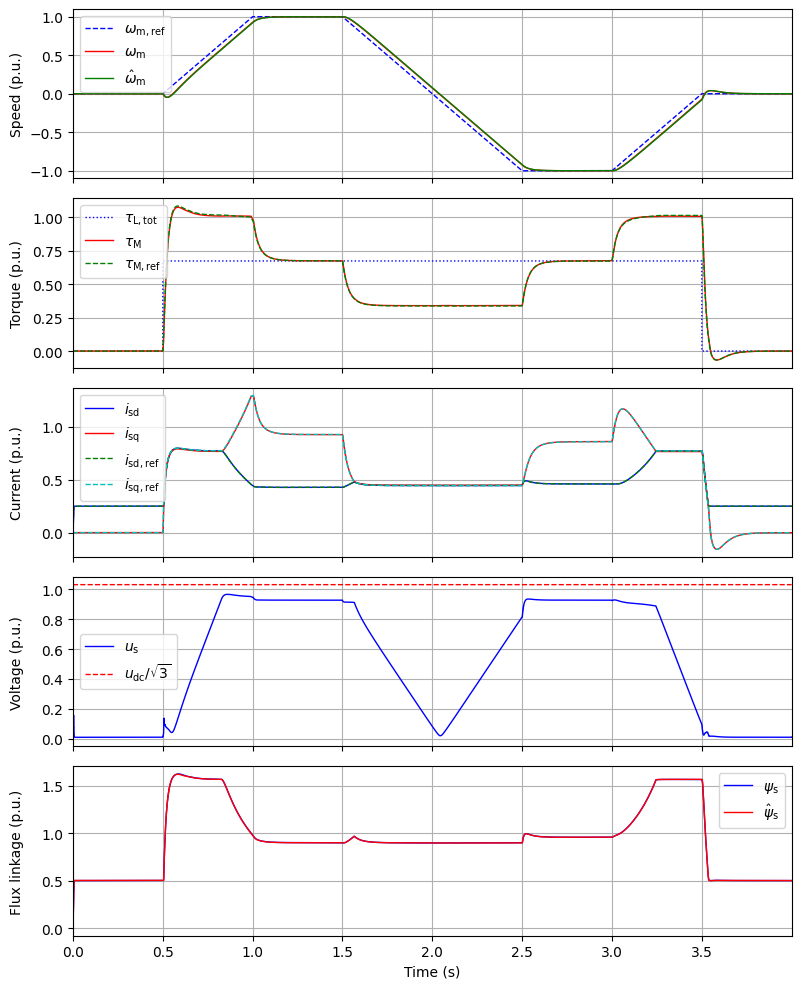

In [7]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=4)
plot(sim, base)